In [1]:
# First we need to import all the necessary toolboxes...
from scipy.optimize import fsolve 
from scipy.interpolate import interp1d
# import all the standard math functions and plotting stuff we'd want from numpy and matplotlib
from numpy import*
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib inline 
import pandas as pd

# Chapter 5 Transient 1D example
A stainless steel plate (thickness = 120 mm, $\rho C_p$ = 3.87x10$^6$ J/m$^3$K, $k$ = 15 W/mK) undergoes a heat-treating process where it is suddenly taken from a 500 $^o$C furnace and quenched in a 25$^o$C oil bath ($h$ = 500 W/m$^2$K. You are asked to determine how long before the centerline temperature will reach 200 $^o$C.

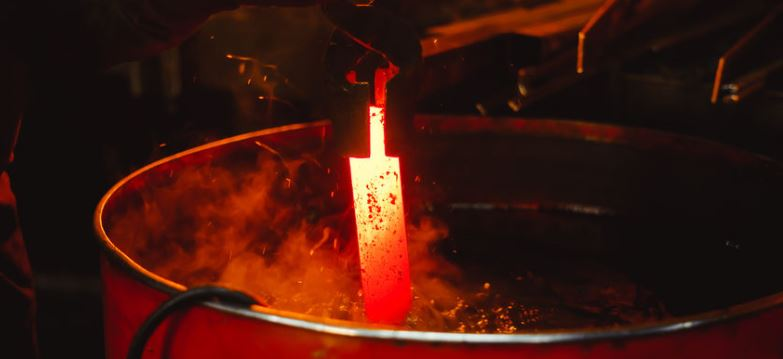!



### Assumptions:
- 1-D conduction
- symmetrical about the central axis
- constant properties (i.e., $k$'s)
- no internal heat generation ($\dot{q}$ = 0)

### Analysis:
First, we want to check the Biot number to see if we can use the lumped-capacitance method:

$$
Bi_L = \frac{hL}{k} = 4 >> 0.1
$$

where the $Bi$ for the whole plate is 4, so we'll need to actually model the interior of the plate. To set this up, let's first recognize the symmetry about the centerline of the plate and then create our nodal network:

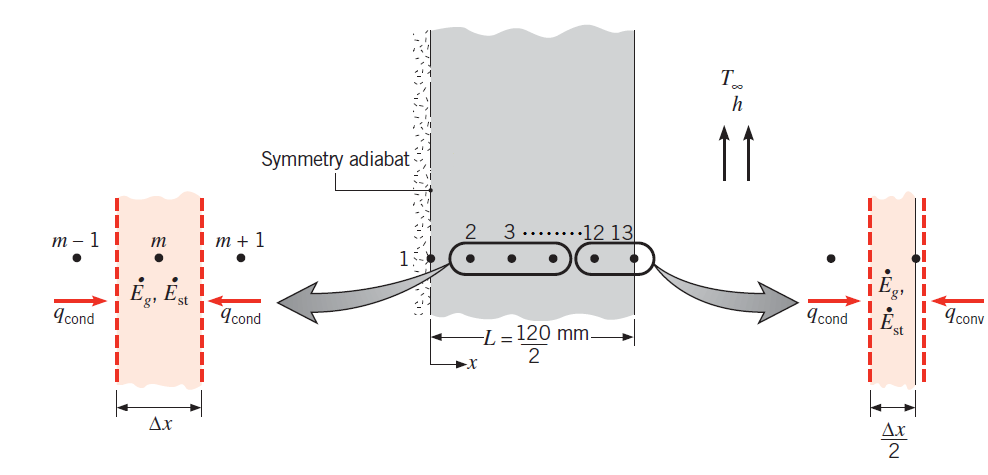

where we have 13 nodes total and $\Delta x$ = 5 mm. We can further define the following parameters:
- the thermal diffusivity, $\alpha = \frac{k}{\rho C}$ = 3.88x10$^{-6}$ m$^2$/s
- the $Bi_{\Delta x} = \frac{h \Delta x}{k}$ = 0.1667
- the $Fo = \frac{\alpha \Delta t}{\Delta x^2}$ = 0.1550

From these assumptions we can build our node equations based on an $explicit$ approach:

Nodes 1-12 (i.e., interior nodes):

$$
T^{P+1}_m = Fo\left[T^{P}_{m-1} + T^{P}_{m+1} + \frac{\dot{q}\Delta x^2}{k}\right] + \left(1-2Fo\right)T^{P}_m
$$

... where at the adiabatic boundary (i.e., node 1): $T^{P}_{m-1}=T^{P}_{m+1}$

Node 13 (externior node):

$$
T^{P+1}_{13} = 2Fo\left[T^{P}_{12} + BiT_\infty + \frac{\dot{q}\Delta x^2}{2k}\right] + \left(1-2Fo-2BiFo\right)T^{P}_{13}
$$

We also need to check our stability condition to ensure that $\Delta t$ is not too big:

$$
Fo\left(1+Bi\right) \leq 1/2
$$

... which implies that our time step cannot be greater than 1.93 seconds, so let's pick 1 sec.

In [2]:
# plate parameters
L = 0.120  # [m]
k = 15  # [W/mK]
rCp = 3.87e6  # [J/m3K] = rho*heat capacity
Ti = 500 + 273  # [K]
alpha = k/(rCp)  # thermal diffusivity
dx = 0.005  # [m]
xtot = int(L/2/dx+1)  # total number of nodes
xx = arange(0,L/2+dx,dx)  # distance space

# oil parameters
Tinf = 25+273  # [K]
h = 500  # [W/m2K]

# system parameters
dt = 1  # [sec]
tfin = 1000  # total time: make sure tfin/dt = integer!!
tt = arange(0,tfin+dt,dt)  # time space

Bi = h*dx/k  # Biot number
Fo = alpha*dt/(dx**2)
# check Fo
if Fo*(1+Bi) <= 0.5:
    print('dt is "good"')
else:
    print('dt is too big ... try:')
    dtnew = 0.5/(1+Bi)*dx**2/alpha
    sys.exit()

# set up Temperature matrix
T = ones((len(xx),int(tfin/dt)+1))*Ti  # [K]

# solve T(node,timestep)
for p in range(1,int(tfin/dt)+1):  # 1000 seconds worth of time steps since dt = 1
    # interior nodes
    T[0,p] = Fo*(2*T[1,p-1]) + (1-2*Fo)*T[0,p-1]  # adiabatic node 1
    for m in range(1,xtot-1):  # nodes 2-12
        T[m,p] = Fo*(T[m-1,p-1]+T[m+1,p-1]) + (1-2*Fo)*T[m,p-1]
    
    # exterior node
    T[xtot-1,p] = 2*Fo*(T[xtot-2,p-1] + Bi*Tinf) + \
                (1 - 2*Fo - 2*Bi*Fo)*T[xtot-1,p-1]

TT = T-273  # [C]
Tcenter = interp1d(TT[0, :], tt[:]) # creates a function to find time to reach a given temp
print(f'The time it takes for the centerline temp to reach 200C is {Tcenter(200):0.2f} sec')

dt is "good"
The time it takes for the centerline temp to reach 200C is 930.75 sec


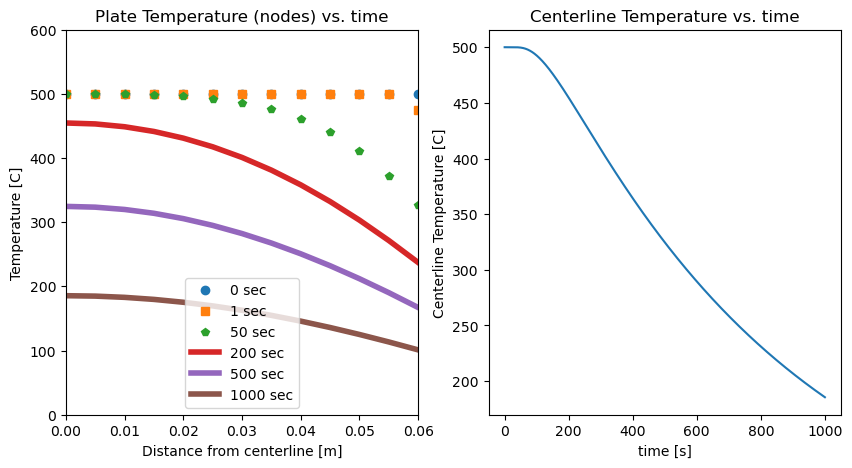

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # setting the plot up in this way allows us to put them side-by-side

# plot 1
ax[0].set_xlabel('Distance from centerline [m]')
ax[0].set_xlim([0, 0.06])
ax[0].set_ylabel('Temperature [C]')
ax[0].set_ylim([0, 600])
ax[0].plot(xx, TT[:, 0], 'o', label='0 sec')
ax[0].plot(xx, TT[:, int(1/dt)], 's', label='1 sec')
ax[0].plot(xx, TT[:, int(50/dt)], 'p', label='50 sec')
ax[0].plot(xx, TT[:, int(200/dt)], linewidth=4, label='200 sec')
ax[0].plot(xx, TT[:, int(500/dt)], linewidth=4, label='500 sec')
ax[0].plot(xx, TT[:, int(1000/dt)], linewidth=4, label='1000 sec')
ax[0].legend()
ax[0].set_title('Plate Temperature (nodes) vs. time')

# plot 2
ax[1].set_title('Centerline Temperature vs. time')
ax[1].plot(tt, TT[0, :])
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('Centerline Temperature [C]')
plt.show()